# Aplikacja Tomografu
## Paweł Mazurkiewicz 156145
## Filip Michalski 155947

## Import potrzebnych bibliotek

In [23]:
import pydicom
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import glob
import os
import math
import ipywidgets as widgets
from ipywidgets import IntSlider
from IPython.display import display, clear_output
from skimage.io import imread
from datetime import datetime
from scipy.signal import convolve
from skimage.metrics import mean_squared_error
from matplotlib.widgets import Slider, Button


from save_dicom import save_as_dicom

## Konwerter plików dicom

In [2]:
image_dir = "./images"
image_files = [f for f in os.listdir(image_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif'))]

# --- Widgety do wyboru pliku i wprowadzenia danych
file_dropdown = widgets.Dropdown(options=image_files, description="Obraz:")
patient_name = widgets.Text(value="Jan Kowalski", description="Imię i nazwisko:")
patient_id = widgets.Text(value="123456", description="ID pacjenta:")
study_date = widgets.Text(value=datetime.today().strftime("%Y%m%d"), description="Data (YYYYMMDD):")
comments = widgets.Text(value="Brak komentarza", description="Komentarz:")
save_button = widgets.Button(description="Zapisz jako DICOM", button_style='success')

output = widgets.Output()

def on_save_clicked(b):
    with output:
        output.clear_output()
        file_path = os.path.join(image_dir, file_dropdown.value)
        img = imread(file_path, as_gray=True)  # wczytanie w odcieniach szarości
        
        # Dane pacjenta
        print(patient_name.value)
        patient_data = {
            "PatientName": patient_name.value,
            "PatientID": patient_id.value,
            "ImageComments": comments.value,
        }

        # Nazwa wyjściowego pliku
        dicom_filename = os.path.splitext(file_dropdown.value)[0] + ".dcm"
        output_path = os.path.join(image_dir, dicom_filename)
        
        # Zapis
        save_as_dicom(output_path, img, patient_data)
        
        print(f"✅ Plik DICOM zapisany: {output_path}")
        print(f"🗓️ Data badania: {study_date.value}")
        plt.imshow(img, cmap='gray')
        plt.title("Zapisany obraz")
        plt.axis("off")
        plt.show()

save_button.on_click(on_save_clicked)

# --- Wyświetlenie interfejsu
display(widgets.VBox([
    file_dropdown,
    patient_name,
    patient_id,
    study_date,
    comments,
    save_button,
    output
]))

## Funkcja Algorytmu Bresenhama oraz funkcje wiązki emiter -> detektor

In [3]:
def bresenham(x0, y0, x1, y1):
    dx = x1 - x0
    dy = y1 - y0

    xsign = 1 if dx > 0 else -1
    ysign = 1 if dy > 0 else -1

    dx = abs(dx)
    dy = abs(dy)

    if dx > dy:
        xx, xy, yx, yy = xsign, 0, 0, ysign
    else:
        dx, dy = dy, dx
        xx, xy, yx, yy = 0, ysign, xsign, 0

    D = 2 * dy - dx
    y = 0

    for x in range(dx + 1):
        yield x0 + x * xx + y * yx, y0 + x * xy + y * yy
        if D >= 0:
            y += 1
            D -= 2 * dx
        D += 2 * dy
        
def simulate_ray(image, x_e, y_e, x_d, y_d):
    height, width = image.shape
    total = 0

    for x, y in bresenham(int(round(x_e)), int(round(y_e)), int(round(x_d)), int(round(y_d))):
        if 0 <= x < width and 0 <= y < height:
            total += image[y, x]
    return total

## Wczytanie plików 

In [4]:
folder_path = "./images"

dicom_files = glob.glob(os.path.join(folder_path, "*.dcm"))

file_names = [os.path.basename(f) for f in dicom_files]

dropdown = widgets.Dropdown(
    options=file_names,
    description='Plik DICOM:',
    disabled=False,
)

selected_file = None

def on_file_selected(change):
    global selected_file
    selected_file = os.path.join(folder_path, change['new'])
    print(f"Wybrano plik: {selected_file}")

dropdown.observe(on_file_selected, names='value')

display(dropdown)

Dropdown(description='Plik DICOM:', options=('Kropka.dcm', 'CT_ScoutView.dcm', 'SADDLE_PE.dcm', 'CT_ScoutView-…

Wybrano plik: ./images/CT_ScoutView-large.dcm


## Filtrowanie sinogramu

In [36]:
odpowiedz = True
def filter_sinogram(sinogram):
    kernel_size = 61
    kernel = []
    kernel_start_offset = -(kernel_size // 2)
    kernel_end_offset = kernel_size // 2 if kernel_size % 2 == 0 else (kernel_size // 2) + 1

    for i in range(kernel_start_offset, kernel_end_offset):
        if i == 0:
            kernel.append(1)
        elif i % 2 == 0:
            kernel.append(0)
        else:
            kernel.append((-4 / (np.pi ** 2) / i ** 2))

    kernel = np.array(kernel)
    filtered_sinogram = np.array([np.convolve(row, kernel, mode='same') for row in sinogram])
    # filtered_sinogram = np.clip(filtered_sinogram,0,np.percentile(filtered_sinogram,99))

    return filtered_sinogram
        
   
    
 
przelacznik = widgets.ToggleButtons(
    options=['Tak', 'Nie'],
    description='Zastosować filtrowanie?:',
    disabled=False,
    button_style=''  # 'success', 'info', 'warning', 'danger' lub ''
)

# Funkcja, która przypisuje wartość do zmiennej
def on_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        global odpowiedz
        odpowiedz = change['new']
        print(f'Wybrano: {odpowiedz}')

# Reagujemy na zmianę wyboru
przelacznik.observe(on_change)

# Wyświetlamy widget
display(przelacznik)



ToggleButtons(description='Zastosować filtrowanie?:', options=('Tak', 'Nie'), value='Tak')

Wybrano: Nie


## Metryka błędu

In [44]:
def calculate_rmse(original, reconstructed):
    original = original.astype(np.float64)
    reconstructed = reconstructed.astype(np.float64)
    mse = np.mean((original - reconstructed) ** 2)
    return np.sqrt(mse)

### Wizualizacja promieni tomografu oraz wybór jego parametrów

W tym fragmencie kodu przygotowano wizualizację rozkładu promieni w symulowanym układzie tomograficznym. Głównym celem jest umożliwienie interaktywnego sterowania parametrami geometrycznymi układu, takimi jak liczba emiterów i detektorów, rozpiętość ich rozmieszczenia oraz krok kątowy między kolejnymi iteracjami.

#### **Zmienne globalne:**
Na początku inicjowane są zmienne globalne:
- `delta_alpha`: początkowo ustawiony na 1 – oznacza krok kątowy obrotu układu emiterów.
- `num_emiters`, `num_detectors`: liczba emiterów i detektorów ustawiona domyślnie na 500.
- `emitter_span`, `detector_span`: rozpiętość układu emiterów.

#### **Wczytanie i przetworzenie obrazu:**
- Obraz DICOM jest wczytywany przy pomocy biblioteki `pydicom`.
- Następnie piksele obrazu są **normalizowane do zakresu 0–255**, a wynik jest konwertowany do typu `uint8`, by można było go poprawnie wyświetlić jako obraz w skali szarości.
- Obliczane są wymiary obrazu i jego środek (`center_x`, `center_y`), a także promień `R`, który określa odległość emiterów i detektorów od środka obrazu (na przeciwnych krańcach).

#### **Funkcja `draw_rays`:**
Funkcja odpowiada za wizualizację promieni przechodzących przez obraz, przy określonym kącie. Wewnątrz funkcji:
- Aktualizowane są zmienne globalne (przy pomocy `global`), aby późniejsze komórki kodu mogły korzystać z tych wartości.
- W pętli `for` generowane są kolejne pozycje emiterów i detektorów oraz rysowane są czerwone linie reprezentujące promienie.

#### **Interaktywny interfejs:**
Na końcu kodu zastosowano interfejs, który pozwala użytkownikowi dynamicznie zmieniać:
- **liczbę emiterów**,  
- **rozpiętość układu**,  
- **kątowy krok**.

Zmienione wartości od razu aktualizują wizualizację, co daje intuicyjny pogląd na to, jak zmiany w geometrii wpływają na pokrycie obrazu promieniami.
Te zmienne potem są aplikowane do obliczeń sinogramu i rekonstrukcji.

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import math
import pydicom
import ipywidgets as widgets
from IPython.display import display

delta_alpha=1
angle_limit = 180
num_angles = int(angle_limit / delta_alpha)
num_emitters = 500
num_detectors = 500
emitter_angle_span = math.radians(40)  


def draw_rays_fanbeam(num_pairs=100, angle_limit_ = 180, angle_span=30, angle_step=1):
    global delta_alpha, num_emitters, num_detectors, emitter_angle_span, angle_limit, num_angles
    
    # Update global parameters
    delta_alpha = angle_step
    num_emitters = num_pairs
    num_detectors = num_pairs
    emitter_angle_span = math.radians(angle_span)
    angle_limit = angle_limit_
    num_angles = int(angle_limit / delta_alpha)
    
    # Visualization setup
    plt.figure(figsize=(8, 8))
    plt.imshow(normalized, cmap='gray')
    plt.title(f"Fan-beam Geometry\nAngle Span: {angle_span}° | Pairs: {num_pairs} | Angle Step: {angle_step}°")
    
    # Draw center point
    plt.scatter(center_x, center_y, color='blue', s=50, label='Center')
    
    # Choose a specific projection angle (90 degrees for visualization)
    theta = math.radians(90)
    
    # Calculate emitter angles (angular spacing)
    emitter_angles = np.linspace(-emitter_angle_span/2, emitter_angle_span/2, num_emitters)
    
    # Central emitter and detector positions
    x_center_emitter = center_x + R * math.cos(theta)
    y_center_emitter = center_y + R * math.sin(theta)
    x_center_detector = center_x - R * math.cos(theta)
    y_center_detector = center_y - R * math.sin(theta)
    
    # Draw emitter and detector arcs
    emitter_arc = plt.Circle((center_x, center_y), R, color='red', fill=False, linestyle='--', alpha=0.3, label='Emitter Arc')
    detector_arc = plt.Circle((center_x, center_y), R, color='green', fill=False, linestyle='--', alpha=0.3, label='Detector Arc')
    plt.gca().add_patch(emitter_arc)
    plt.gca().add_patch(detector_arc)
    
    # Draw all emitter-detector pairs
    for i in range(num_pairs):
        # Emitter position (angular)
        emitter_angle = emitter_angles[i]
        x_e = center_x + R * math.cos(theta + emitter_angle)
        y_e = center_y + R * math.sin(theta + emitter_angle)
        
        # Corresponding detector position (exactly opposite)
        # Calculate the angle to the detector (180° opposite to emitter)
        detector_angle = emitter_angle + math.pi  # Add 180 degrees in radians
        x_d = center_x + R * math.cos(theta - detector_angle)
        y_d = center_y + R * math.sin(theta - detector_angle)
        
        # Draw ray connecting emitter-detector pair
        plt.plot([x_e, x_d], [y_e, y_d], color='orange', alpha=0.2, linewidth=0.5)
        
        # Draw emitters and detectors (only for every 10th to avoid clutter)
        if i % (num_pairs//10) == 0 or i == num_pairs-1:
            plt.scatter(x_e, y_e, color='red', s=10, alpha=0.7)
            plt.scatter(x_d, y_d, color='green', s=10, alpha=0.7)
            # Add labels for the first and last pair
            if i == 0:
                plt.text(x_e, y_e, ' First', color='white', fontsize=8, verticalalignment='center')
                plt.text(x_d, y_d, ' First', color='white', fontsize=8, verticalalignment='center')
            elif i == num_pairs-1:
                plt.text(x_e, y_e, ' Last ', color='white', fontsize=8, verticalalignment='center')
                plt.text(x_d, y_d, ' Last ', color='white', fontsize=8, verticalalignment='center')
    
    # Draw central ray
    plt.plot([x_center_emitter, x_center_detector], 
             [y_center_emitter, y_center_detector], 
             color='yellow', linewidth=2, label='Central Ray')
    
    plt.legend()
    plt.axis("off")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

# Load DICOM image
ds = pydicom.dcmread(selected_file)
pixel_array = ds.pixel_array
normalized = ((pixel_array - np.min(pixel_array)) / 
             (np.max(pixel_array) - np.min(pixel_array)) * 255).astype(np.uint8)

height, width = normalized.shape
center_x, center_y = width / 2, height / 2
R = math.hypot(width, height)

# Create interactive widget
widgets.interact(
    draw_rays_fanbeam,
    num_pairs=widgets.IntSlider(min=10, max=500, step=10, value=100, description='Emitter-Detector Pairs'),
    angle_limit_=widgets.IntSlider(min=1, max=180, step=1, value=180, description='Angle Limit'),
    angle_span=widgets.FloatSlider(min=5, max=360, step=5, value=30, description='Angle Span (°)'),
    angle_step=widgets.FloatSlider(min=0.5, max=5, step=0.5, value=1, description='Rotation Step (°)')
)

interactive(children=(IntSlider(value=100, description='Emitter-Detector Pairs', max=500, min=10, step=10), In…

<function __main__.draw_rays_fanbeam(num_pairs=100, angle_limit_=180, angle_span=30, angle_step=1)>

## Symulacja całego tomografu

10
(1513, 1300)


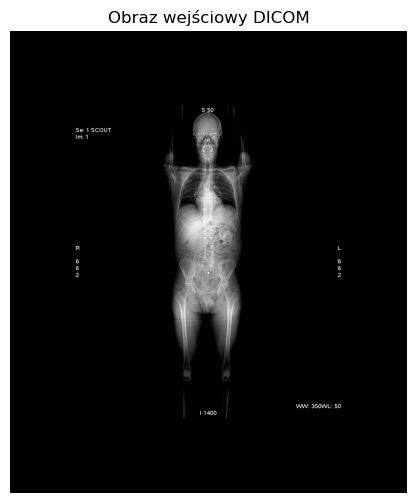

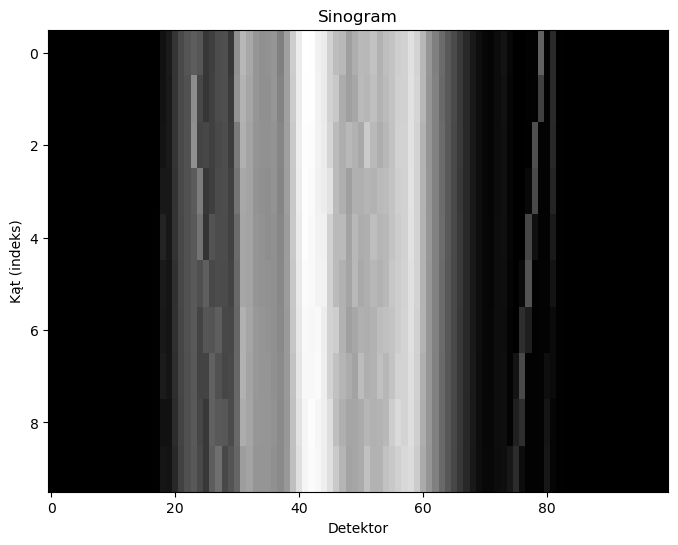

Final MSE: 34.155253


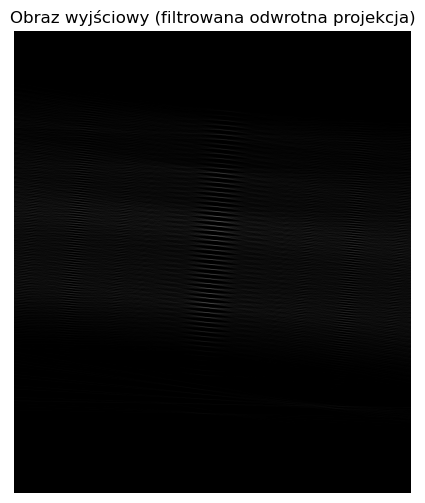

In [45]:

print(angle_limit)
ds = pydicom.dcmread(selected_file)
pixel_array = ds.pixel_array
normalized = ((pixel_array - np.min(pixel_array)) / 
            (np.max(pixel_array) - np.min(pixel_array)) * 255).astype(np.uint8)
print(normalized.shape)

plt.figure(figsize=(6,6))
plt.imshow(normalized, cmap='gray')
plt.title("Obraz wejściowy DICOM")
plt.axis("off")
plt.show()

height, width = normalized.shape
center_x, center_y = width / 2, height / 2
R = math.hypot(width, height)*1.5

# =============================================
# Step 1: Create Sinogram
# =============================================
sinogram = np.zeros((num_angles, num_detectors))

for angle_idx, alpha in enumerate(np.linspace(1, angle_limit, num_angles)):
    theta = math.radians(alpha)
    
    # Main emitter and detector positions (central ones)
    x_center_emitter = center_x + R * math.cos(theta)
    y_center_emitter = center_y + R * math.sin(theta)
    x_center_detector = center_x - R * math.cos(theta)
    y_center_detector = center_y - R * math.sin(theta)

    # For emitters: calculate positions based on angular spacing
    emitter_angles = np.linspace(-emitter_angle_span/2, emitter_angle_span/2, num_emitters)
    
    # For detectors: keep linear spacing

    for det_idx in range(num_detectors):
        # Calculate emitter position (angular spacing)
        emitter_angle = emitter_angles[det_idx]
        x_e = center_x + R * math.cos(theta + emitter_angle)
        y_e = center_y + R * math.sin(theta + emitter_angle)
        
        # Calculate detector position (linear spacing)
        detector_angle = emitter_angle + math.pi  # Add 180 degrees in radians
        x_d = center_x + R * math.cos(theta - detector_angle)
        y_d = center_y + R * math.sin(theta - detector_angle)

        sinogram[angle_idx, det_idx] = simulate_ray(normalized, x_e, y_e, x_d, y_d)

# Display sinogram
sinogram_norm = ((sinogram - sinogram.min()) / 
                (sinogram.max() - sinogram.min()) * 255).astype(np.uint8)
plt.figure(figsize=(8,6))
plt.imshow(sinogram_norm, cmap='gray', aspect='auto')
plt.title("Sinogram")
plt.xlabel("Detektor")
plt.ylabel("Kąt (indeks)")
plt.show()

# =============================================
# Step 2: Filter Sinogram
# =============================================
filtered_sinogram = sinogram
if odpowiedz == "Tak":
    filtered_sinogram = filter_sinogram(sinogram)
    plt.figure(figsize=(8,6))
    plt.imshow(filtered_sinogram, cmap='gray', aspect='auto')
    plt.title("Sinogram po filtrowaniu")
    plt.xlabel("Detektor")
    plt.ylabel("Kąt (indeks)")
    plt.show()

# =============================================
# Step 3: Reconstruction (Filtered Backprojection)
# =============================================
reconstruction = np.zeros_like(normalized, dtype=np.float64)

for angle_idx, alpha in enumerate(np.linspace(1, angle_limit, num_angles)):
    theta = math.radians(alpha)
    
    # Main emitter and detector positions
    x_center_emitter = center_x + R * math.cos(theta)
    y_center_emitter = center_y + R * math.sin(theta)
    x_center_detector = center_x - R * math.cos(theta)
    y_center_detector = center_y - R * math.sin(theta)

    # Emitter angles and detector positions (same as during creation)
    emitter_angles = np.linspace(-emitter_angle_span/2, emitter_angle_span/2, num_emitters)

    for det_idx in range(num_detectors):
        # Emitter position (angular)
        emitter_angle = emitter_angles[det_idx]
        x_e = center_x + R * math.cos(theta + emitter_angle)
        y_e = center_y + R * math.sin(theta + emitter_angle)
        
        detector_angle = emitter_angle + math.pi  # Add 180 degrees in radians
        x_d = center_x + R * math.cos(theta - detector_angle)
        y_d = center_y + R * math.sin(theta - detector_angle)
        

        ray_value = filtered_sinogram[angle_idx, det_idx]

        for x, y in bresenham(int(round(x_e)), int(round(y_e)), 
                            int(round(x_d)), int(round(y_d))):
            if 0 <= x < width and 0 <= y < height:
                reconstruction[y, x] += ray_value

# Normalize reconstruction
reconstruction_norm = ((reconstruction - reconstruction.min()) / 
                    (reconstruction.max() - reconstruction.min()) * 255).astype(np.uint8)
mse_final = calculate_rmse(normalized, reconstruction_norm)
print(f"Final RMSE: {mse_final:.6f}")

plt.figure(figsize=(6,6))
plt.imshow(reconstruction_norm, cmap='gray')
plt.title("Obraz wyjściowy (filtrowana odwrotna projekcja)")
plt.axis("off")
plt.show()

# Raport
### Wykonali Filip Michalski 155947, Paweł Mazurkiewicz 156145
## Język programowania oraz biblioteki
Aplikacja została napisana w języku python z użyciem bibliotek: ```pydicom, matplotlib, numpy, ipywidgets, scipy```
## Model Tomografu
Zosał zastosowany model z równoległymi detektorami/emiterami
## Opis głównych funkcji programu:
### **Funkcja: `bresenham(x0, y0, x1, y1)`**

Funkcja ta implementuje algorytm Bresenhama, służący do wyznaczania pikesli, które w przybliżeniu tworzą prostą między dwoma zadanymi punktami przez które będzie przechodzić wiązka z emitera do detektora. Algorytm ten cechuje się efektywnością oraz tym, że operuje wyłącznie na liczbach całkowitych poprzez uproszczenia, co sprawia, że jest dobrze dopasowany do reprezentacji obrazu w postaci siatki pikseli.

W zależności od kierunku linii, funkcja automatycznie przestawia współrzędne tak, aby zawsze iterować po dłuższej osi. Dla każdego kolejnego kroku generowane są współrzędne `(x, y)`, które można traktować jako kolejne piksele leżące na trasie promienia.


### **Funkcja: `simulate_ray(image, x_e, y_e, x_d, y_d)`**

Funkcja służy do symulowania przejścia promienia przez macierz złożoną z pikseli. Jej zadaniem jest wyznaczenie całkowitej sumy intensywności pikseli, przez które przechodzi dany promień, łączący punkt emisji `(x_e, y_e)` z punktem detekcji `(x_d, y_d)`.

W pierwszym kroku funkcja określa rozmiary obrazu, a następnie za pomocą algorytmu `bresenham` uzyskuje współrzędne wszystkich pikseli leżących na trasie wiązki. Jeśli punkt znajduje się wewnątrz obrazu, jego wartość (jasność piksela) jest dodawana do zmiennej `total`.

Zwracana wartość `total` reprezentuje całkowitą „gęstość” napotkaną przez promień — jest to symulowana wartość odczytu z detektora. Funkcja jest wykorzystywana do funkcji Radona do wyznaczenia **sinogramu** obrazu.

### Funkcja `filter_sinogram(sinogram)`

Ta funkcja implementuje filtr Ram-Laka (Ramp filter) używany w rekonstrukcji tomograficznej metodą filtrowanej projekcji wstecznej.

#### Działanie filtra:
1. **Tworzenie jądra splotu**:
   - Rozmiar jądra: 61 punktów
   - Wartości jądra:
     - 1 dla pozycji centralnej (i=0)
     - 0 dla parzystych indeksów
     - -4/(π²i²) dla nieparzystych indeksów (gdzie i to offset od środka)

2. **Proces filtrowania**:
   - Dla każdego rzutu (wiersza sinogramu) wykonuje się splot z filtrem
### Funkcja `save_as_dicom(file_name, img, patient_data)`

1. Tworzenie metadanych:

    - meta = Dataset() - tworzy podstawowy obiekt metadanych DICOM

    - Ustawia identyfikatory (UID) wymagane przez standard DICOM

    - Określa format kodowania (ExplicitVRLittleEndian)

2. Inicjalizacja pliku DICOM:

    - FileDataset - główny obiekt reprezentujący plik DICOM

    - Dodaje preambułę (128 bajtów zer)

3. Ustawienie parametrów obrazu:

    - Informacje o pacjencie (PatientName, PatientID)

    - Typ obrazu (CT)

    - Wymiary obrazu (Rows, Columns)

    - Parametry techniczne (BitsStored, BitsAllocated, SamplesPerPixel)

    - Typ obrazowania (ORIGINAL\PRIMARY\AXIAL)

    - Interpretacja fotometryczna (MONOCHROME2)

4. Walidacja i zapis:

    - validate_file_meta() - sprawdza poprawność metadanych

    - Konwersja obrazu na bajty (tobytes())

    - Zapis do pliku (save_as())
## RMSE
RMSE (Root Mean Square Error) to miara błędu między dwoma obrazami. Określa, jak bardzo piksele obrazu zrekonstruowanego różnią się od oryginalnego.

- Dla każdego piksela liczymy różnicę

- Podnosimy tę różnicę do kwadratu

- Uśredniamy wszystkie różnice
- Bierzemy pierwiastek z tej wartości